In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae import *
import torch
import random
from torchvision.transforms import transforms as T
from pathlib import Path
from config import *
from utils import *
from conv_utils import *

import numpy as np
import platform
import json

architecture='conv_ae'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_conv_sl_16_run_2
num selection:1 - exp name:4_wheel_system_01-25-23:10:09:11_conv_extended_params_sl_16


In [3]:
select_exp = '0'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_conv_sl_16_run_2


In [5]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /home/roberto/Documents/backup_rob/repo/esa_fdir/time_series_anomaly_detection/model_results/esa_exploration/conv_ae/4_wheel_system_conv_sl_16_run_2/summary.csv


In [6]:
summary.reset_index().head(10)

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,49,13,"trainCONVAE_cfdc0_00012_12_activation=Relu,bat...",154155,0.004030,0.003245
1,48,17,"trainCONVAE_cfdc0_00040_40_activation=Relu,bat...",149015,0.006043,0.004766
2,47,1,"trainCONVAE_cfdc0_00015_15_activation=Relu,bat...",41255,0.013142,0.012168
3,46,48,"trainCONVAE_cfdc0_00018_18_activation=Relu,bat...",41255,0.015408,0.014305
4,45,43,"trainCONVAE_cfdc0_00010_10_activation=Relu,bat...",147103,0.018720,0.018907
5,44,37,"trainCONVAE_cfdc0_00025_25_activation=Relu,bat...",147103,0.021582,0.020969
6,43,34,"trainCONVAE_cfdc0_00029_29_activation=Relu,bat...",147103,0.021582,0.020969
7,42,20,"trainCONVAE_cfdc0_00020_20_activation=Relu,bat...",147963,0.021909,0.021037
8,41,38,"trainCONVAE_cfdc0_00046_46_activation=Relu,bat...",147963,0.028525,0.027791
9,40,11,"trainCONVAE_cfdc0_00002_2_activation=Relu,batc...",149015,0.027317,0.028582


In [8]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'activation': 'Relu', 'batch_size': 100, 'epochs': 200, 'filter_num': 128, 'kernel_size': 3, 'latent_dim': 70, 'lr': 0.0009, 'lr_patience': 5, 'n_layers': 2, 'seq_in_length': 16}


In [9]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path))
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [10]:
if platform.node()=='leonard':
    device='cpu'
else:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

In [12]:
cols = cfg['dataset']['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

columns_subset = params_conf['columns_subset']
dataset_subset = params_conf['dataset_subset']

dataset = params_conf['dataset']
train_val_split = params_conf['train_val_split']

target = params_conf['target']
batch_size = params_conf['batch_size']
sequence_length = params_conf['sequence_length']
out_window = params_conf['out_window']
predict = params_conf['predict']
activation = params_conf['activation']
kernel_size = params_conf['kernel_size']
filter_num = params_conf['filter_num']
latent_dim = params_conf['latent_dim']
n_layers = params_conf['n_layers']

In [13]:
model = CONV_AE(in_channel=1,heigth=params_conf['sequence_length'], width=len(cfg['dataset']['columns']),
                        kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                 latent_dim=params_conf['latent_dim'], \
        n_layers=params_conf['n_layers'], activation = params_conf['activation']()).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
par_nums = checkpoint['parameters_number']
model.to(device).eval()
print(count_parameters(model))
model

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
154155


CONV_AE(
  (act): ReLU()
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (enc_lay_1): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (enc_lay_2): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [14]:
transform = T.Compose([
                       T.ToTensor(),
                       ])
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, cfg['dataset']['scaled'],cfg['dataset']['columns_subset']
                  , cfg['dataset']['dataset_subset'], cfg['dataset']['columns'], 
                 cfg['dataset']['train_val_split'], cfg['dataset']['sequence_length']
                  , cfg['dataset']['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [17]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches_conv(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 160


In [18]:
yo = model(x.to(device)).squeeze().to(device)
xs = torch.squeeze(x).to(device)
x_plot = x.squeeze().to(device)

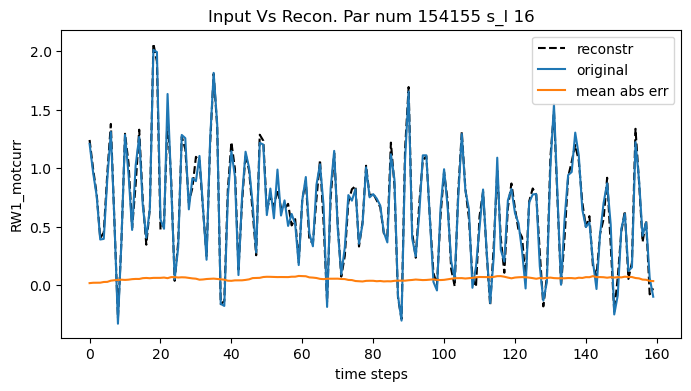

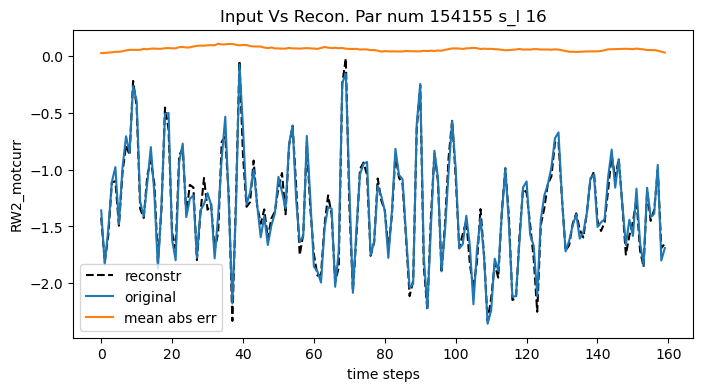

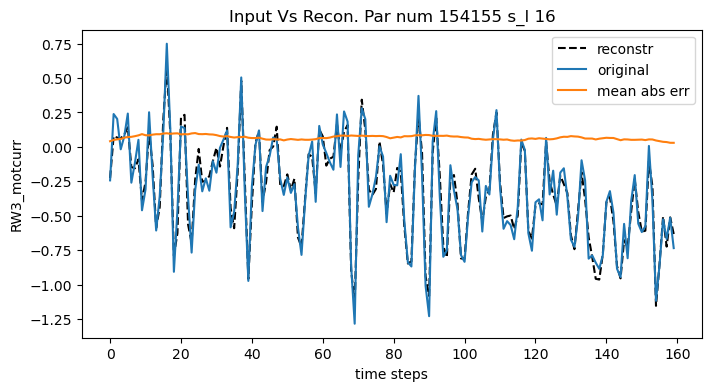

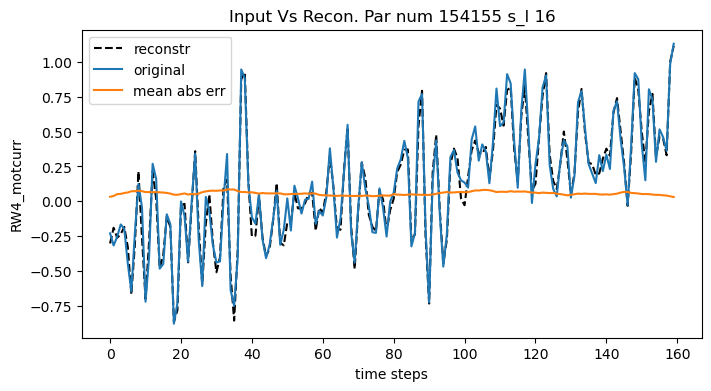

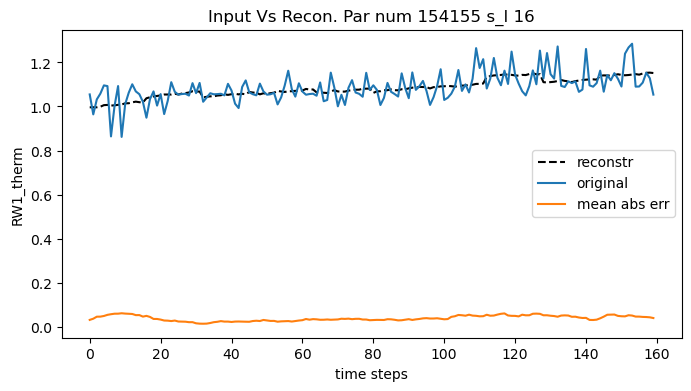

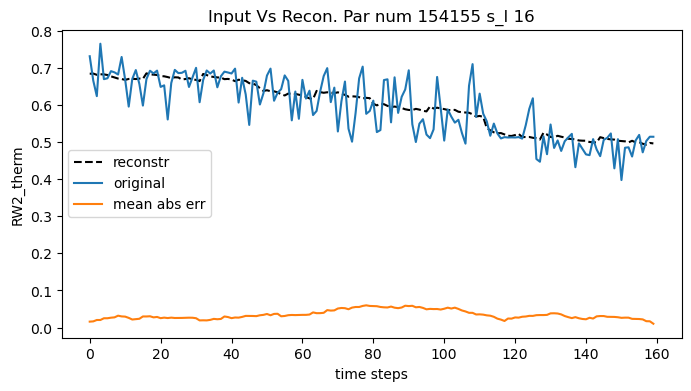

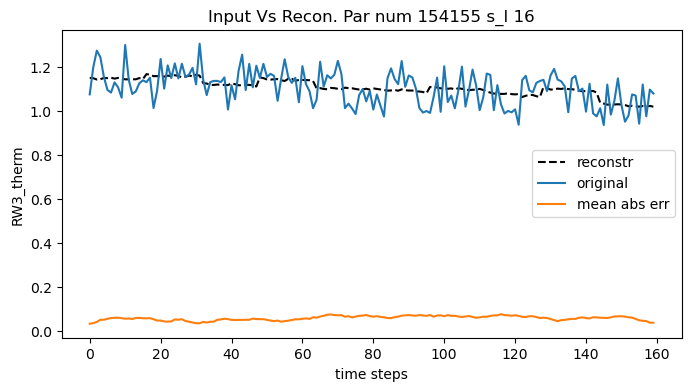

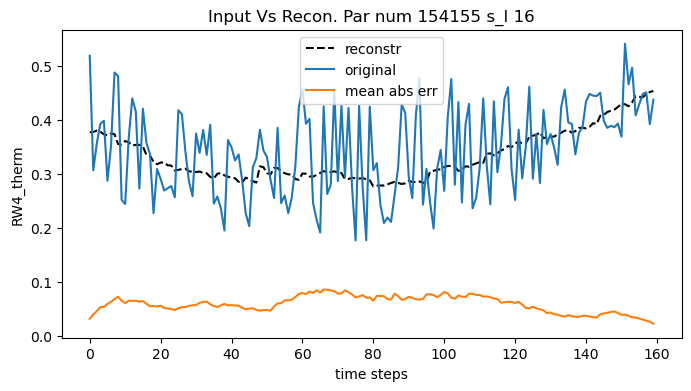

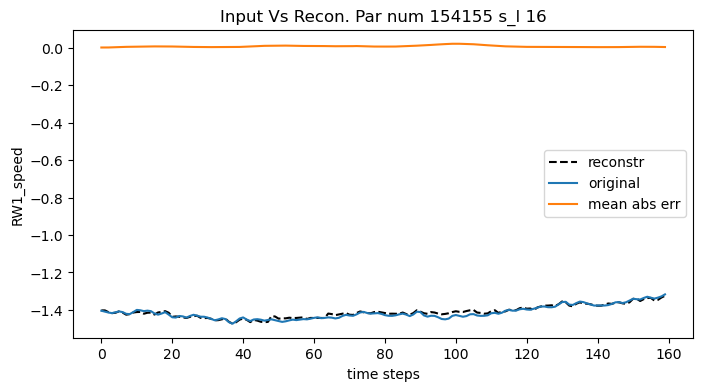

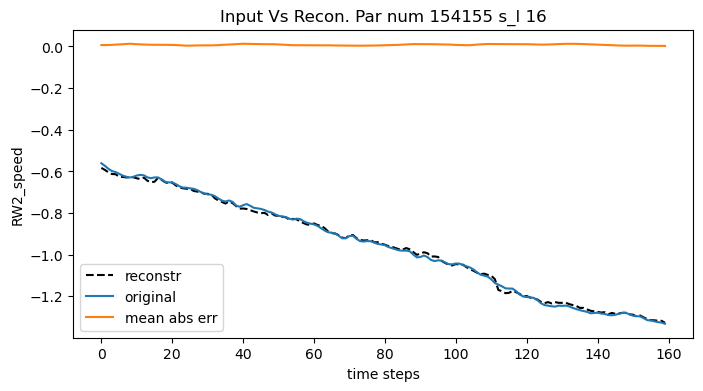

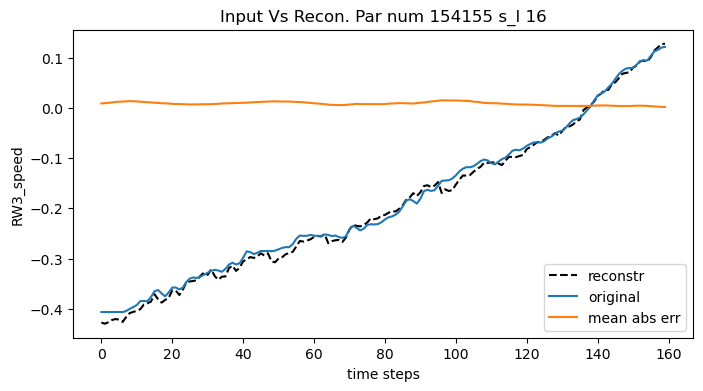

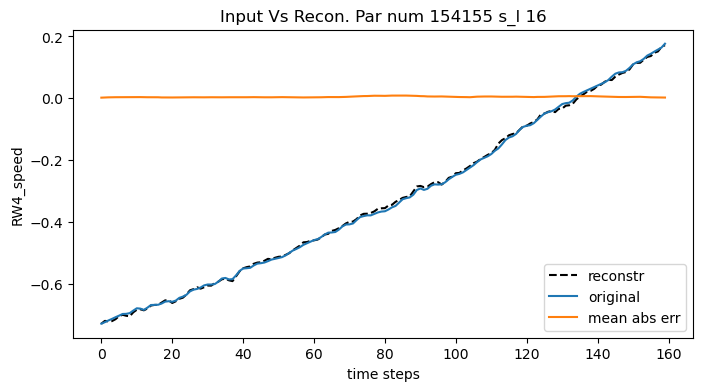

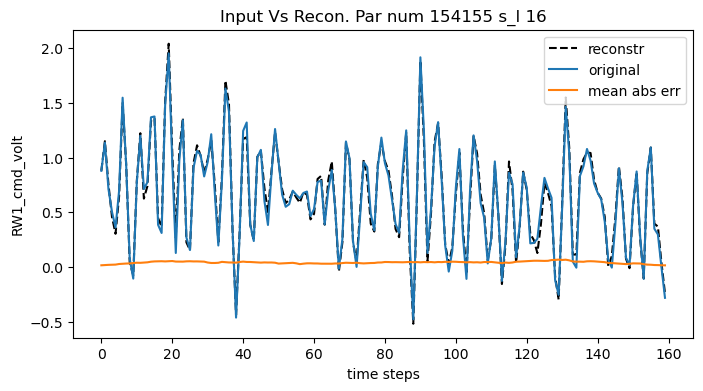

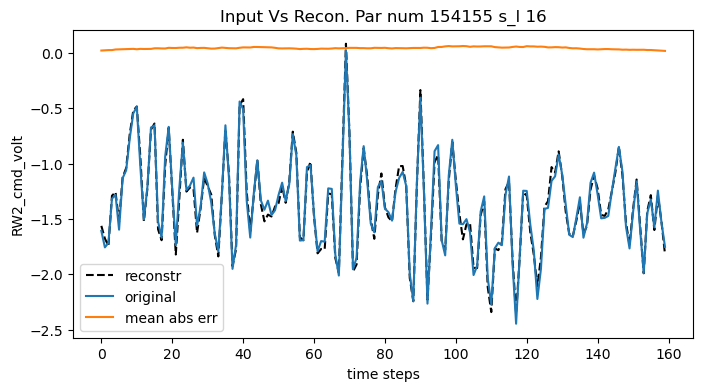

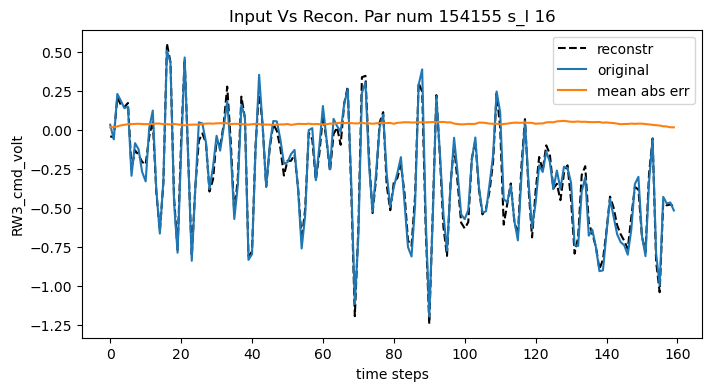

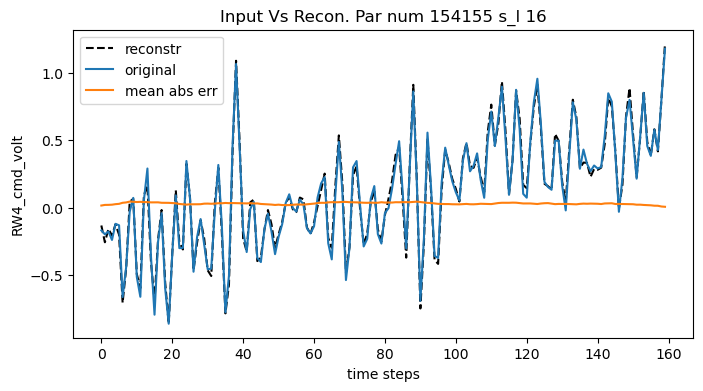

In [19]:
show_results(x_plot, yo,cols,
    model_name, params_conf,
    par_nums, shift,num_batch,
    architecture='conv_ae',
    save=False,)